<a href="https://colab.research.google.com/github/annisapraditha/ML_Production-main/blob/main/CBIR_ML(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/ML

/content/drive/My Drive/ML


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/ML/chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
cd /tmp/chest_xray

/tmp/chest_xray


In [ ]:
%ls

test/  train/


In [ ]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras import callbacks
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
train_dir = 'train'
test_dir = 'test'

In [ ]:
import cv2
import numpy as np
import os

test_data = []
test_label = []
for r, d, f in os.walk(test_dir):
    for file in f:
        if ".jpeg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, ((224,224)))
            test_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            test_label.append(label)

test_data = np.array(test_data)
test_label = np.array(test_label)

In [ ]:
import cv2
import numpy as np
import os

train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpeg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, ((224,224)))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

In [ ]:
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Test Data = ", test_data.shape)
print("Test Label = ", test_label.shape)

Train Data =  (856, 224, 224, 3)
Train Label =  (856,)
Test Data =  (624, 224, 224, 3)
Test Label =  (624,)


In [ ]:
# Normalisasi dataset
print("Data sebelum di-normalisasi ", test_data[0][0][0])

x_test = test_data.astype('float32') / 255.0
x_train = train_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_test[0][0][0])

Data sebelum di-normalisasi  [137 137 137]
Data setelah di-normalisasi  [0.5372549 0.5372549 0.5372549]


In [ ]:
# Transformasi label encoder
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", test_label[100:110])

lb = LabelEncoder()
y_test = lb.fit_transform(test_label)
y_train = lb.fit_transform(train_label)

print("Label setelah di-encoder ", y_test[100:110])

Label sebelum di-encoder  ['NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL'
 'NORMAL' 'NORMAL']
Label setelah di-encoder  [0 0 0 0 0 0 0 0 0 0]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./225,
    validation_split=0.2,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    color_mode='rgb',
    shuffle=True
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    color_mode='rgb',
    shuffle=True
)

Found 686 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 170 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten
# Feature Extraction Layer
model = Sequential()

model.add(InputLayer(input_shape=[100,100,3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=516, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Flatten())

In [ ]:
# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 64)       0

In [ ]:
# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['acc'])
H = model.fit(x_test, y_test, batch_size=20, epochs=100, validation_data=(x_train, y_train))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
32/32 [==============================] - 11s 48ms/step - loss: 0.6720 - acc: 0.6154 - val_loss: 0.6770 - val_acc: 0.5631
Epoch 2/100
32/32 [==============================] - 1s 28ms/step - loss: 0.6203 - acc: 0.6250 - val_loss: 0.5997 - val_acc: 0.5631
Epoch 3/100
32/32 [==============================] - 1s 28ms/step - loss: 0.5214 - acc: 0.7308 - val_loss: 0.4819 - val_acc: 0.8084
Epoch 4/100
32/32 [==============================] - 1s 28ms/step - loss: 0.3732 - acc: 0.8702 - val_loss: 0.4465 - val_acc: 0.7582
Epoch 5/100
32/32 [==============================] - 1s 28ms/step - loss: 0.2861 - acc: 0.8926 - val_loss: 0.3049 - val_acc: 0.8738
Epoch 6/100
32/32 [==============================] - 1s 29ms/step - loss: 0.2343 - acc: 0.9167 - val_loss: 0.3010 - val_acc: 0.8762
Epoch 7/100
32/32 [==============================] - 1s 28ms/step - loss: 0.2163 - acc: 0.9231 - val_loss: 0.2975 - val_acc: 0.8727
Epoch 8/100
32/32 [==============================] - 1s 28ms/step - loss: 0

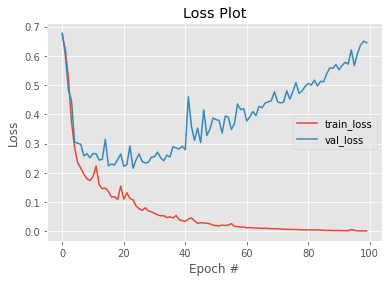

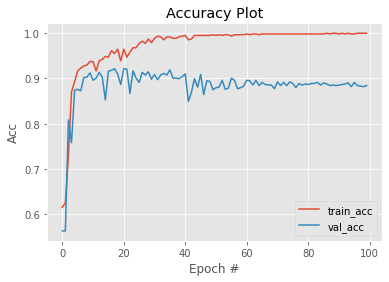

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(x_train)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_train, labels))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       374
           1       0.95      0.84      0.89       482

    accuracy                           0.88       856
   macro avg       0.88      0.89      0.88       856
weighted avg       0.89      0.88      0.88       856



In [ ]:
from keras.models import save_model
model = save_model(model,'CNN.h5')

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications import MobileNet

In [ ]:
import tensorflow as tf
from keras import layers, Model
from keras.layers import InputLayer, Activation, Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, Concatenate, Input, GlobalAveragePooling2D
from keras.models import Sequential

model_1 = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
class Combin1:
  def build(model_1,classes):
    headModel = model_1.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation='relu')(headModel)
    headModel = Dense(64, activation='relu')(headModel)
    headModel = Dense(1, activation='relu')(headModel)
    headModel = Dense(classes, activation='sigmoid')(headModel)
    return headModel

In [ ]:
headModel2 = Combin1.build(model_1, 1)
model2 =Model(inputs=model_1.input, outputs=headModel2)

In [ ]:
for layer in model_1.layers:
  layer.trainable = False

In [ ]:
model2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
model2.compile(
    optimizer=Adam(lr=0.00001, decay= 0.001/20),
    loss ='binary_crossentropy',
    metrics =['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
test=model2.fit(
    train_generator,
     validation_data = val_generator,
     epochs=100,
     steps_per_epoch= 10,
     batch_size=32,

)

Epoch 1/100
10/10 [==============================] - 17s 2s/step - loss: 0.6914 - accuracy: 0.6126 - val_loss: 0.6008 - val_accuracy: 0.7882
Epoch 2/100
10/10 [==============================] - 13s 1s/step - loss: 0.5637 - accuracy: 0.7881 - val_loss: 0.5377 - val_accuracy: 0.8118
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 0.5152 - accuracy: 0.8874 - val_loss: 0.4953 - val_accuracy: 0.9000
Epoch 4/100
10/10 [==============================] - 13s 1s/step - loss: 0.4695 - accuracy: 0.9007 - val_loss: 0.4936 - val_accuracy: 0.9235
Epoch 5/100
10/10 [==============================] - 13s 1s/step - loss: 0.4458 - accuracy: 0.9636 - val_loss: 0.5052 - val_accuracy: 0.8706
Epoch 6/100
10/10 [==============================] - 13s 1s/step - loss: 0.4455 - accuracy: 0.9000 - val_loss: 0.4958 - val_accuracy: 0.9235
Epoch 7/100
10/10 [==============================] - 13s 1s/step - loss: 0.4626 - accuracy: 0.9531 - val_loss: 0.5070 - val_accuracy: 0.9353
Epoch 8/100
1

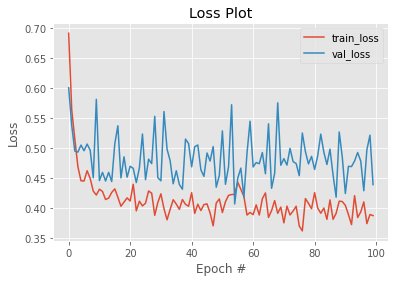

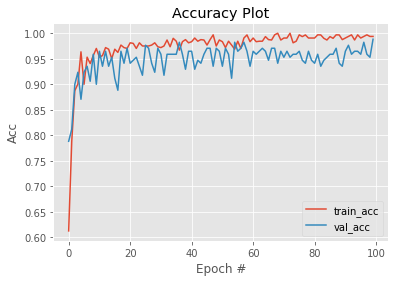

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), test.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), test.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), test.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), test.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred = model2.predict(x_train)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_train, labels))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       374
           1       1.00      0.97      0.99       482

    accuracy                           0.98       856
   macro avg       0.98      0.99      0.98       856
weighted avg       0.99      0.98      0.98       856



In [ ]:
from keras.models import save_model
model_1 = save_model(model2,'MobileNet.h5')